# Классификация текстов

   сначала бейзлайн 


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import re

In [2]:
train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

<a list of 230 Patch objects>

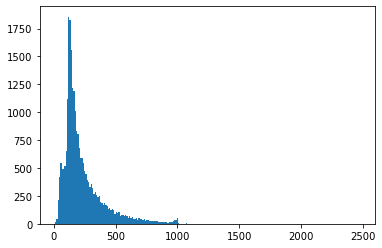

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [4]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data



def eval_model(model, test_df, X='review'):
    preds = model.predict(test_df[X])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

Words count 27299


In [5]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression(random_state=0)

linear_model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

In [6]:
linear_model.fit(train_df['review'], train_df['is_positive'])

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(random_state=0))])

In [7]:
eval_model(linear_model, test_df, 'review')

Test accuracy = 88.32%


In [8]:
X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

C:\Users\Pavel\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Pavel\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note l

In [9]:
net_model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

net_model.summary()
net_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          1747136   
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,747,907
Trainable params: 1,747,907
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = net_model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 11s 56ms/step - loss: 0.6074 - accuracy: 0.7442 - val_loss: 0.4105 - val_accuracy: 0.8332
Epoch 2/10
196/196 [==============================] - 13s 64ms/step - loss: 0.3015 - accuracy: 0.8775 - val_loss: 0.3015 - val_accuracy: 0.8701
Epoch 3/10
196/196 [==============================] - 11s 55ms/step - loss: 0.1795 - accuracy: 0.9327 - val_loss: 0.2960 - val_accuracy: 0.8731
Epoch 4/10
196/196 [==============================] - 11s 54ms/step - loss: 0.0990 - accuracy: 0.9700 - val_loss: 0.3237 - val_accuracy: 0.8717
Epoch 5/10
196/196 [==============================] - 10s 53ms/step - loss: 0.0471 - accuracy: 0.9890 - val_loss: 0.3647 - val_accuracy: 0.8701
Epoch 6/10
196/196 [==============================] - 11s 55ms/step - loss: 0.0198 - accuracy: 0.9974 - val_loss: 0.4074 - val_accuracy: 0.8679
Epoch 7/10
196/196 [==============================] - 11s 54ms/step - loss: 0.0077 - accuracy: 0.9994 - val_loss: 0.4462 - val_accuracy:

In [11]:
# 0.8657

### 1. Посмотрите на токены если будут мусорные добавьте их в стоп слова и обучите заново

In [12]:
train_df.loc[train_df['review'].str.contains('<b')].head(2)

,is_positive,review
1,0,This show comes up with interesting locations ...
3,0,Spoilers ahead if you want to call them that.....



   удалим html


In [13]:
train_df['preprocessed_review'] = train_df['review'].apply(lambda x: BeautifulSoup(x, "lxml").text)
test_df['preprocessed_review'] = test_df['review'].apply(lambda x: BeautifulSoup(x, "lxml").text)   


   удалим пунктуацию


In [14]:
def remove_punctuation(sentence):
    sentence = re.sub(r'[^\w\s]', ' ', sentence)
    return sentence

In [15]:
train_df['preprocessed_review'] = train_df['preprocessed_review'].apply(lambda x: remove_punctuation(x))
test_df['preprocessed_review'] = test_df['preprocessed_review'].apply(lambda x: remove_punctuation(x))   


   приведем к нижнему регистру


In [16]:
train_df['preprocessed_review'] = train_df['preprocessed_review'].apply(lambda x: x.lower())
test_df['preprocessed_review'] = test_df['preprocessed_review'].apply(lambda x: x.lower())  


   удалим стоп-слова


In [17]:
import nltk

In [18]:
stopwords = nltk.corpus.stopwords.words('english')

In [19]:
train_df['preprocessed_review'] = train_df['preprocessed_review'].\
        apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

test_df['preprocessed_review'] = test_df['preprocessed_review'].\
        apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

<a list of 252 Patch objects>

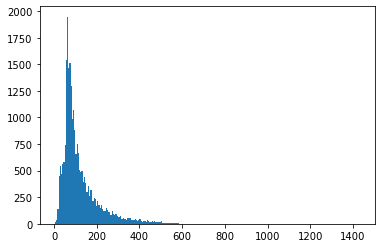

In [20]:
_, _, hist = plt.hist(train_df.preprocessed_review.apply(lambda text: len(text.split())), bins='auto')
hist


   конечно, можно почистить еще (удалить цифры и расширить стоп слова), но пока оставим так, мы уже значительно сократили длину 

In [21]:
linear_model.fit(train_df['preprocessed_review'], train_df['is_positive'])
eval_model(linear_model, test_df, 'preprocessed_review')

Test accuracy = 88.33%



   рост качества на 0.01



   Сетевую модель придется пересобрать, так как меняется размер входных данных и количество слов.


In [22]:
words_counter = Counter((word for text in train_df.preprocessed_review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 19979


In [23]:
X_train = convert(train_df.preprocessed_review, word2idx, 600)
X_test = convert(test_df.preprocessed_review, word2idx, 600)

C:\Users\Pavel\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Pavel\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note l

In [24]:
net_model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

net_model.summary()
net_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 64)           1278656   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,279,427
Trainable params: 1,279,427
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = net_model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10,
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 7s 35ms/step - loss: 0.5895 - accuracy: 0.6956 - val_loss: 0.3983 - val_accuracy: 0.8522
Epoch 2/10
196/196 [==============================] - 7s 36ms/step - loss: 0.2960 - accuracy: 0.8839 - val_loss: 0.2987 - val_accuracy: 0.8749
Epoch 3/10
196/196 [==============================] - 7s 36ms/step - loss: 0.1874 - accuracy: 0.9314 - val_loss: 0.2977 - val_accuracy: 0.8756
Epoch 4/10
196/196 [==============================] - 7s 36ms/step - loss: 0.1160 - accuracy: 0.9642 - val_loss: 0.3114 - val_accuracy: 0.8758
Epoch 5/10
196/196 [==============================] - 7s 36ms/step - loss: 0.0652 - accuracy: 0.9844 - val_loss: 0.3486 - val_accuracy: 0.8712
Epoch 6/10
196/196 [==============================] - 7s 36ms/step - loss: 0.0335 - accuracy: 0.9938 - val_loss: 0.3838 - val_accuracy: 0.8682
Epoch 7/10
196/196 [==============================] - 7s 34ms/step - loss: 0.0173 - accuracy: 0.9980 - val_loss: 0.4197 - val_accuracy: 0.8667


   0.8657 - было, 0.8676 стало. Пока что значительного роста нет, зато уменьшено время обучения с ~11 до 7 секунд на эпоху


### 2. Проверьте повысилось ли качество на стандартных подходах при лемматизации

In [27]:
from nltk.tokenize import word_tokenize

In [28]:
train_df['lemz_review'] = train_df['preprocessed_review'].apply(lambda x: word_tokenize(x))
test_df['lemz_review'] = test_df['preprocessed_review'].apply(lambda x: word_tokenize(x))

In [30]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [33]:
train_df['lemz_review'] = train_df['lemz_review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

In [34]:
test_df['lemz_review'] = test_df['lemz_review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

In [42]:
linear_model.fit(train_df['lemz_review'], train_df['is_positive'])
eval_model(linear_model, test_df, 'lemz_review')

Test accuracy = 87.94%



   87.94 против 88,73


In [45]:
words_counter = Counter((word for text in train_df.lemz_review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

X_train = convert(train_df.lemz_review, word2idx, 600)
X_test = convert(test_df.lemz_review, word2idx, 600)

net_model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

net_model.summary()
net_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = net_model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10,
          validation_data=(X_test, test_df.is_positive))

Words count 18050


C:\Users\Pavel\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Pavel\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note l

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 64)           1155200   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 1,155,971
Trainable params: 1,155,971
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 7s 35ms/step - loss: 0.6470 - accuracy: 0.6398 - val_los


    пока топчемся на месте


### 3. Удалите из текстов какие-то из сущностей(не удалите а замените их тегом). Запустите классификатор.

In [81]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')


   Заменим всё из первоначальных обзоровом (предобработка ухудшает работу выделения сущностей)


In [95]:
# функция честно найдена на stackoverflow :)
def sub_ner(text):
    doc = nlp(text)
    newString = text
    for e in reversed(doc.ents): #reversed to not modify the offsets of other entities when substituting
        start = e.start_char
        end = start + len(e.text)
        newString = newString[:start] + e.label_ + newString[end:]
    return newString        

In [96]:
train_df['sub_ner'] =  train_df['review'].apply(lambda x: sub_ner(x))
test_df['sub_ner'] =  test_df['review'].apply(lambda x: sub_ner(x))

In [97]:
linear_model.fit(train_df['sub_ner'], train_df['is_positive'])
eval_model(linear_model, test_df, 'sub_ner')

Test accuracy = 88.58%


In [98]:
words_counter = Counter((word for text in train_df.sub_ner for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

X_train = convert(train_df.sub_ner, word2idx, 1000)
X_test = convert(test_df.sub_ner, word2idx, 1000)

net_model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

net_model.summary()
net_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = net_model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10,
          validation_data=(X_test, test_df.is_positive))

Words count 22277


C:\Users\Pavel\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Pavel\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note l

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 64)          1425728   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 1,426,499
Trainable params: 1,426,499
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 12s 61ms/step - loss: 0.6243 - accuracy: 0.6907 - val_lo

### 4. Поэкспериментируйте с подходом с сеточками на разных данных (с удалёнными сущностями или без)


  Пу сути мы уже пробовали подавать разные варианты обработки данных. <br>
    существенной разницы в качестве не заметно, зто сократив размер данных можно выиграть в быстродействии <br>
    Возможно, стоило сначала попробовать заменить сущности, а уже потом выполнять задания из предыдущих пунктов
